# <center><span style='color:green'> Household Electricity Consumption </span></center>

## Problem Statement

* Predict the household electricity consumption
* Regression problem

## 1 <span style='color:red'>|</span> Import Libraries

In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#for modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score , r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor , RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

#database
import pymongo

#save the model
import pickle

#to read data
import zipfile

## 2 <span style='color:red'>|</span> Load Dataset

In [25]:
zip_file_path = "cosumption_data.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    df = pd.read_csv("household_power_consumption.txt", delimiter=';')

In [26]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [27]:
df.shape

(2075259, 9)

* Taking a sample of 60000 as data is too large 

In [4]:
df_sample = df.sample(60000)
df_sample.shape

(60000, 9)

## 3 <span style='color:red'>|</span> Exploratory Data Analysis

In [5]:
df_sample.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [6]:
df_sample.drop(['Date','Time'], axis=1, inplace=True)

In [7]:
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1233438,2.632,0.104,240.230,10.800,1.000,0.000,18.0
1309607,?,?,?,?,?,?,NaN
817152,0.728,0.188,241.320,3.000,0.000,0.000,1.0
1623532,0.250,0.000,247.450,1.000,0.000,0.000,0.0
1193085,0.446,0.178,243.280,2.000,0.000,1.000,0.0


In [8]:
df_sample.sample(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1831087,1.348,0.000,240.750,5.600,0.000,0.000,19.0
1003692,1.396,0.152,235.610,6.000,0.000,0.000,0.0
81923,1.526,0.096,240.390,6.200,1.000,1.000,17.0
491388,0.544,0.264,247.820,2.400,1.000,0.000,0.0
1968,0.304,0.142,246.490,1.400,0.000,0.000,0.0
376741,3.448,0.068,235.970,14.600,37.000,0.000,18.0
1799605,1.446,0.084,241.760,6.000,0.000,0.000,19.0
120650,1.868,0.590,239.640,8.000,0.000,2.000,18.0
1081550,1.676,0.106,244.660,6.800,0.000,0.000,0.0
465255,4.692,0.160,234.310,20.000,0.000,37.000,16.0


In [9]:
df_sample.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

#### 3.1 <span style='color:red'>|</span> Check any special character and handle them 

In [10]:
character_check = any(not value.isnumeric() for value in df_sample['Global_active_power'])
character_check

True

In [11]:
character = [value for value in df_sample['Global_active_power'] if not str(value).replace('.','',1).isnumeric()]
set(character)

{'?'}

In [12]:
#Check character in dataframe
special_char = df_sample[df_sample['Global_active_power']=='?']
special_char

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1309607,?,?,?,?,?,?,NaN
1619197,?,?,?,?,?,?,NaN
1986212,?,?,?,?,?,?,NaN
1310951,?,?,?,?,?,?,NaN
1397743,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...
1984992,?,?,?,?,?,?,NaN
1930857,?,?,?,?,?,?,NaN
1934797,?,?,?,?,?,?,NaN
1619919,?,?,?,?,?,?,NaN


* 737/60000 rows and 7/7 columns has special character in it

In [13]:
(737/60000)*100

1.2283333333333333

In [14]:
#drop the data having special character
print("Data before removal of special character :", df_sample.shape)
df_sample.drop(special_char.index, axis=0, inplace=True)
print("Data after removal of special character :", df_sample.shape)

Data before removal of special character : (60000, 7)
Data after removal of special character : (59257, 7)


#### 3.2 <span style='color:red'>|</span> Check duplicates

In [15]:
df_sample.duplicated().sum()

263

* 265 duplicates record found

In [16]:
print("Data with duplicate records :", df_sample.shape)
df_sample.drop_duplicates(inplace=True)
print("Data withour duplicate records :", df_sample.shape)

Data with duplicate records : (59257, 7)
Data withour duplicate records : (58994, 7)


#### 3.3 <span style='color:red'>|</span> Check null values

In [17]:
df_sample.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

* No null values in dataset

#### 3.4 <span style='color:red'>|</span> Convert dtype of columns

In [18]:
df_sample = df_sample.astype(float)

In [19]:
df_sample.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

#### 3.5 <span style='color:red'>|</span> Combining Features

In [20]:
df_sample['meter'] = df_sample['Sub_metering_1'] + df_sample['Sub_metering_2'] + df_sample['Sub_metering_2']

In [21]:
df_sample.drop(['Sub_metering_1','Sub_metering_2','Sub_metering_3'], axis=1, inplace=True)

In [32]:
df_sample.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'meter'],
      dtype='object')

In [28]:
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,meter
1233438,2.632,0.104,240.23,10.8,1.0
817152,0.728,0.188,241.32,3.0,0.0
1623532,0.250,0.000,247.45,1.0,0.0
1193085,0.446,0.178,243.28,2.0,2.0
1321839,0.294,0.226,240.15,1.4,2.0


In [29]:
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,58994.0,1.098659,1.066037,0.076,0.310,0.608,1.534,9.338
Global_reactive_power,58994.0,0.123723,0.112490,0.000,0.048,0.100,0.194,1.190
Voltage,58994.0,240.820611,3.260856,223.490,238.960,240.970,242.890,253.230
Global_intensity,58994.0,4.656969,4.481814,0.200,1.400,2.600,6.400,41.800
meter,58994.0,3.784080,13.551102,0.000,0.000,0.000,2.000,179.000


#### 3.6 <span style='color:red'>|</span> Data Distribution

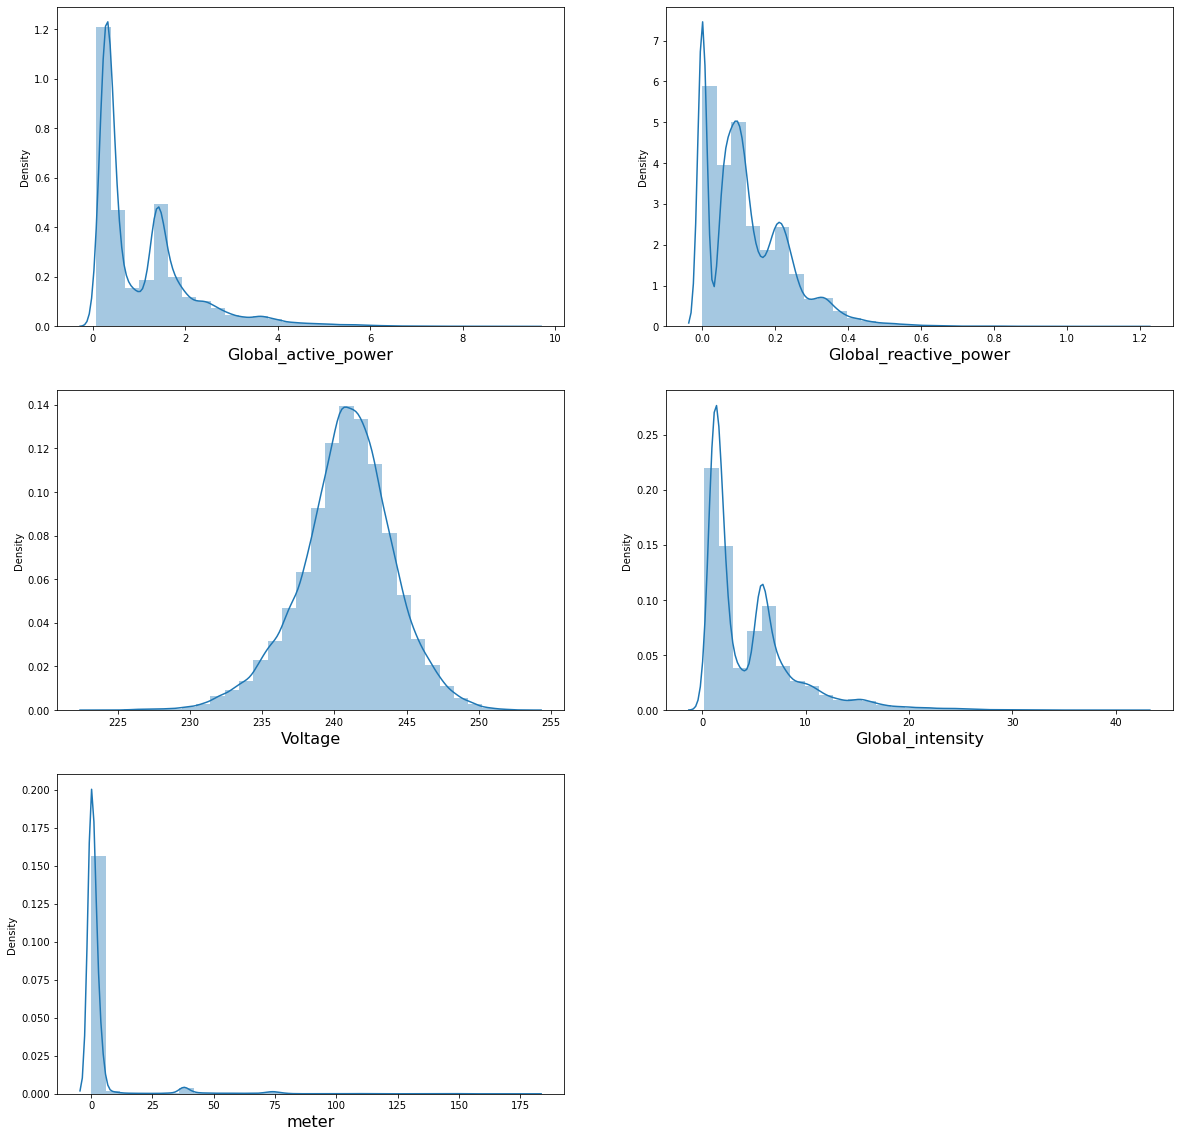

In [35]:
#Data Distribution in each column
plt.figure(figsize=(20,20), facecolor='white')
plotnum =1

for col in df_sample.columns:
    if plotnum <= 5:
        ax = plt.subplot(3,2,plotnum)
        sns.distplot(df_sample[col], bins=30)
        plt.xlabel(col, fontsize=16)
    plotnum += 1
plt.show()

#### 3.7 <span style='color:red'>|</span> Check & Handle outliers

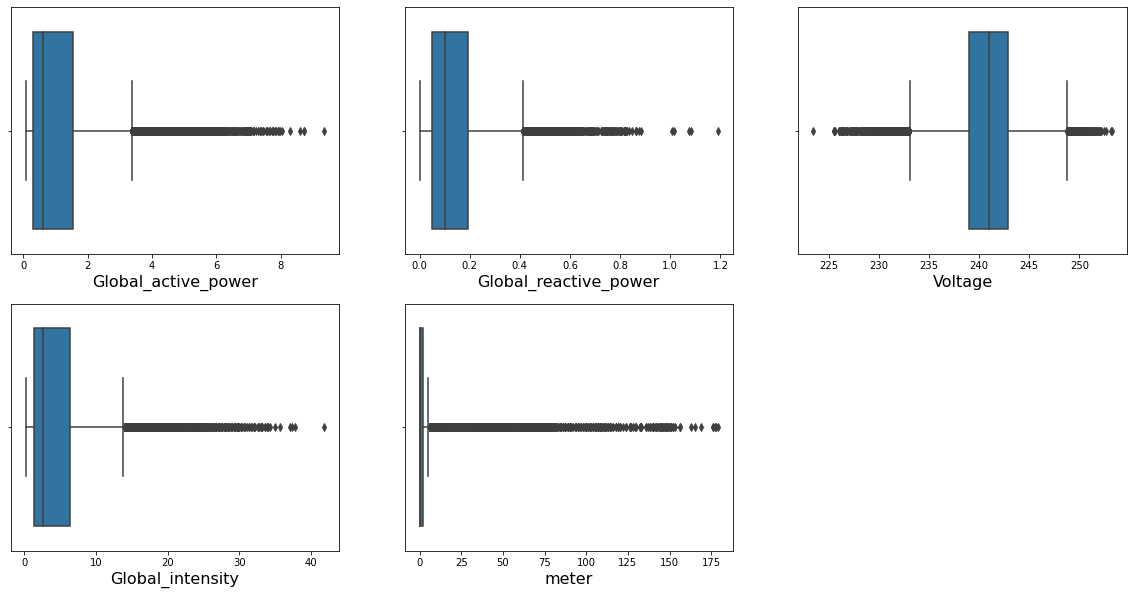

In [37]:
plt.figure(figsize=(20,10))
plotnum = 1

for col in df_sample.columns:
    if plotnum <= 5:
        ax = plt.subplot(2,3,plotnum)
        sns.boxplot(df_sample[col])
        plt.xlabel(col, fontsize=16)
    plotnum += 1
plt.show()

In [51]:
#Handling Outlier

df1 = df_sample.copy()

for col in df1.columns:
    iqr = df1[col].quantile(0.75) - df1[col].quantile(0.25)
    lower_limit = df1[col].quantile(0.25) - (1.5*iqr)
    upper_limit = df1[col].quantile(0.75) + (1.5*iqr)
    
    df1[col] = np.where(df1[col]>upper_limit,upper_limit,np.where(df1[col]<lower_limit,lower_limit,df1[col]))

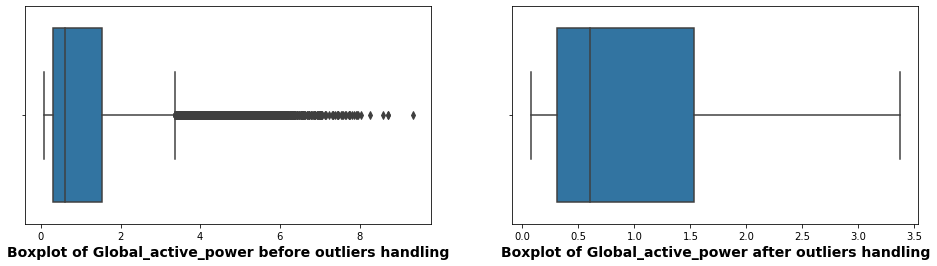

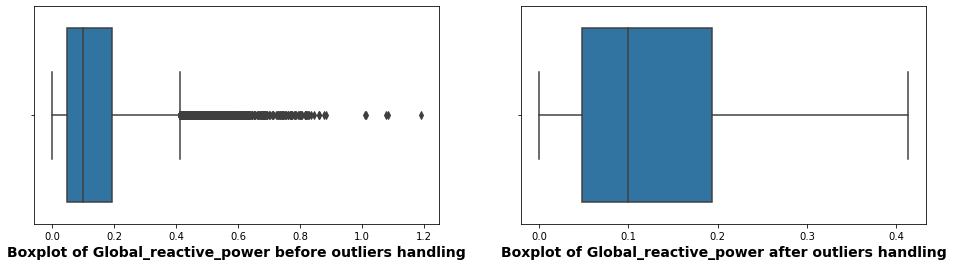

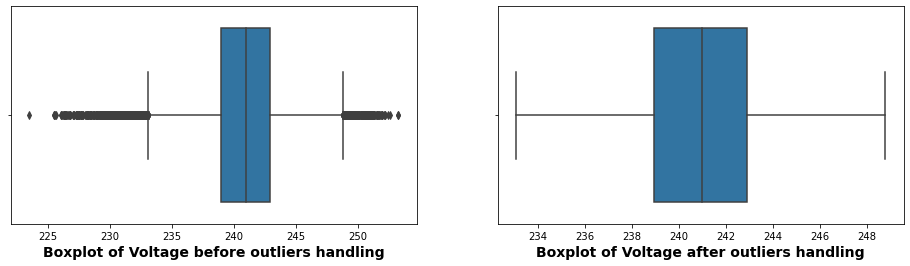

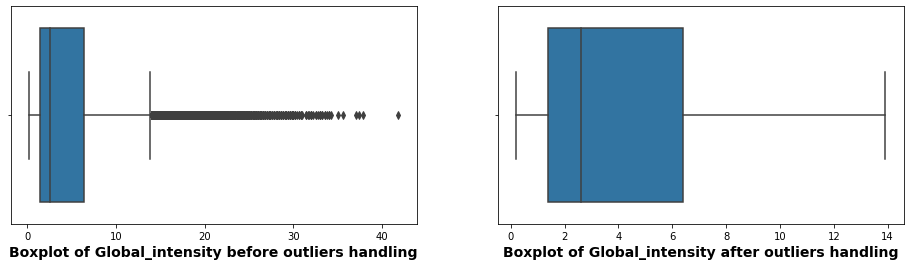

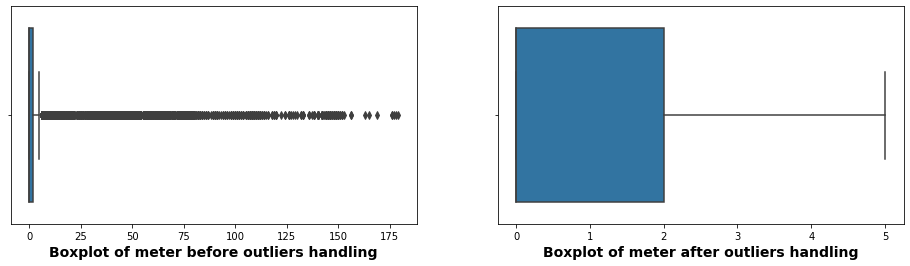

In [64]:
#compare the distribution across quantile

for col in df1.columns:
    
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    sns.boxplot(df_sample[col])
    plt.xlabel(f"Boxplot of {col} before outliers handling", fontsize=14, fontweight='bold')
    
    plt.subplot(122)
    sns.boxplot(df1[col])
    plt.xlabel(f"Boxplot of {col} after outliers handling", fontsize=14, fontweight='bold')

## 4 <span style='color:red'>|</span> Model Building

In [68]:
x= df1.drop('meter', axis=1)
y = df1['meter']

In [69]:
x.shape,y.shape

((58994, 4), (58994,))

#### 4.1 <span style='color:red'>|</span> Train Test Split Dataset

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size=0.20)

#### 4.1 <span style='color:red'>|</span> Standardization

In [71]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

#### 4.3 <span style='color:red'>|</span> Modeling

In [72]:
report = []

In [75]:
models = {
    "Linear Regression" : LinearRegression(),
    "Ridge Regression" : Ridge(),
    "Lasso Regression" : Lasso(),
    "Support Vector Regression" : SVR(),
    "Decision Tree Regressor" : DecisionTreeRegressor(),
    "Random Forest Regressor" : RandomForestRegressor()
}


In [89]:
for i in range(len(models)):
    model = list(models.values())[i] 
    model.fit(x_train,y_train)
    
    #prediction
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    #Training data performance
    n = len(y_train)
    k = x_train.shape[1]
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_adj_r2 = 1-(((1-train_r2)*(n-1))/(n-k-1))
    
    #Test data performance
    n2 = len(y_test)
    k2 = x_test.shape[1]
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_adj_r2 = 1-(((1-test_r2)*(n2-1))/(n2-k2-1))
    
    report.append({"Model": list(models.keys())[i],
                 "Train MSE" : train_mse,
                 "Test MSE" : test_mse,
                 "Train MAE" : train_mae,
                 "Test MAE" : test_mae,
                 "Train R2" : train_r2,
                 "Test R2" : test_r2,
                 "Train Adj R2" : train_adj_r2,
                 "Test Adj R2" : test_adj_r2})

In [90]:
all_models = pd.DataFrame(report)
all_models

,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R2,Test R2,Train Adj R2,Test Adj R2
0,Linear Regression,1.944641,1.955379,1.058670,1.060772,0.261948,2.616539e-01,0.261885,0.261404
1,Ridge Regression,1.944643,1.955420,1.058657,1.060769,0.261947,2.616383e-01,0.261885,0.261388
2,Lasso Regression,2.634829,2.648324,1.352414,1.355161,0.000000,-4.935586e-07,-0.000085,-0.000340
3,Support Vector Regression,2.035497,2.039821,0.834417,0.832355,0.227465,2.297688e-01,0.227400,0.229508
4,Decision Tree Regressor,0.012407,3.459107,0.005883,1.089075,0.995291,-3.061501e-01,0.995291,-0.306593
5,Random Forest Regressor,0.269070,1.933529,0.352266,0.992859,0.897879,2.699043e-01,0.897871,0.269657
